In [37]:
import numpy as np
import matplotlib.pyplot as plt
import mat73
import os
from scipy.io import loadmat


In [24]:
def unitvec_to_cartesian(path_unitvec, height, dist):
    if type(dist) == np.ndarray:
        z_offset = height
        rad = np.sqrt(dist[0] ** 2 + (dist[2] + z_offset) ** 2)
        scaled_path = map_to_cylinder(path_unitvec, rad, axis=1)
    else:
        scaled_path = map_to_cylinder(path_unitvec, dist, axis=2)
    return scaled_path

def map_to_cylinder(path, rad, axis=2):
    # maps points (unit vecs) to cylinder of known radius along axis (default z/2)
    scaled_path = np.empty(path.shape)
    rad_axes = [0, 1, 2]
    rad_axes.remove(axis)
    for i in range(path.shape[0]):
        vec = path[i]
        scale_rad = np.sqrt(np.sum([vec[j] ** 2 for j in rad_axes]))
        scale = rad / scale_rad
        scaled_path[i] = vec * scale
    return scaled_path

def sample_rirs(rirs, n, t_type="circular"):
    if t_type == "circular":
        n_traj, n_heights, L, n_ch, n_points = np.array(rirs).shape
    elif t_type == "linear":
        n_traj = len(rirs)
        L, n_ch, n_points = rirs[0][0].shape
    output = np.empty((n, L))
    for i in range(n):
        ts = np.random.randint(n_traj)
        if t_type == "linear":
            n_heights = len(rirs[ts])
        hs = np.random.randint(n_heights)
        if t_type == "linear":
            L, n_ch, n_points = rirs[ts][hs].shape
        cs = np.random.randint(n_ch)
        ps = np.random.randint(n_points)
        output[i, :] = rirs[ts][hs][:, cs, ps]
    return output


def load_rir_sample(rir_file, n=5, t_type="circular", audio_format="mic"):
    rirs = mat73.loadmat(rir_file)
    rirs = rirs["rirs"][audio_format]
    sample = sample_rirs(rirs, n, t_type=t_type)
    return sample

def load_paths(room_idx, tau_db_dir, center_on_mic=False):
    rooms = [
        "bomb_shelter",
        "gym",
        "pb132",
        "pc226",
        "sa203",
        "sc203",
        "se203",
        "tb103",
        "tc352",
    ]
    room = rooms[room_idx]

    measinfo = loadmat(os.path.join(tau_db_dir, "measinfo.mat"))["measinfo"]
    rirdata = loadmat(os.path.join(tau_db_dir, "rirdata.mat"))["rirdata"][0]

    trajs = measinfo[room_idx][0][4][0]
    heights = measinfo[room_idx][0][5][0]
    dists = measinfo[room_idx][0][6][0]
    mic_pos = measinfo[room_idx][0][7][0]
    traj_type = measinfo[room_idx][0][9][0]
    paths = rirdata[0][1][room_idx][0][2]

    output_paths = np.empty(paths.shape, dtype=object)
    path_metadata = np.empty(paths.shape, dtype=object)
    room_metadata = {
        "room": room,
        "trajectory_type": traj_type,
        "microphone_position": mic_pos,
    }
    for i, traj in enumerate(trajs):
        for j, height in enumerate(heights):
            if traj_type == "circular":
                dist = dists[i]
            elif traj_type == "linear":
                dist = dists[:, i]

            path_unitvec = paths[i, j][0]
            path_dict = {"trajectory": traj, "height": height}
            path_cartesian = unitvec_to_cartesian(path_unitvec, height, dist)
            if center_on_mic:
                path_cartesian += mic_pos
            output_paths[i, j] = path_cartesian
            path_metadata[i, j] = path_dict

    return output_paths, path_metadata, room_metadata

def load_rirs(rir_file, t_type="circular", audio_format="mic"):
    rirs = mat73.loadmat(rir_file)
    rirs = rirs["rirs"][audio_format]
    return rirs

In [25]:
tau_db_path = "/vast/ci411/spatialscaper_dev/datasets/rir_datasets/original_RIRs/TAU-SRIR_DB/"
sample_rir_file = "rirs_01_bomb_shelter.mat"

In [20]:
paths, path_meta, room_meta = load_paths(0, tau_db_path)

In [32]:
paths[0][0].shape

(360, 3)

In [26]:
rirs = load_rirs(os.path.join(tau_db_path, sample_rir_file))

In [30]:
len(rirs[0][0])

7200

In [34]:
rirs[0][0].shape

(7200, 4, 360)

In [62]:
sr = 24000
sample_time = 1/sr
mic_dia = 0.1 #m
v_sound = 330 #m/s

max_shift = (mic_dia / v_sound) / sample_time
print(max_shift)

7.272727272727273


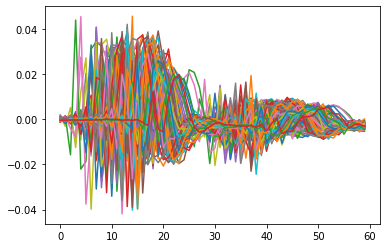

In [69]:
for i in range(36):
    srir_sample = rirs[0][0][:,:,i*10]
    start = 20
    stop = 80
    for i in range(srir_sample.shape[1]):
        rir = srir_sample[:,i]
        plt.plot(rir[start:stop])

[-4, 1, -2]


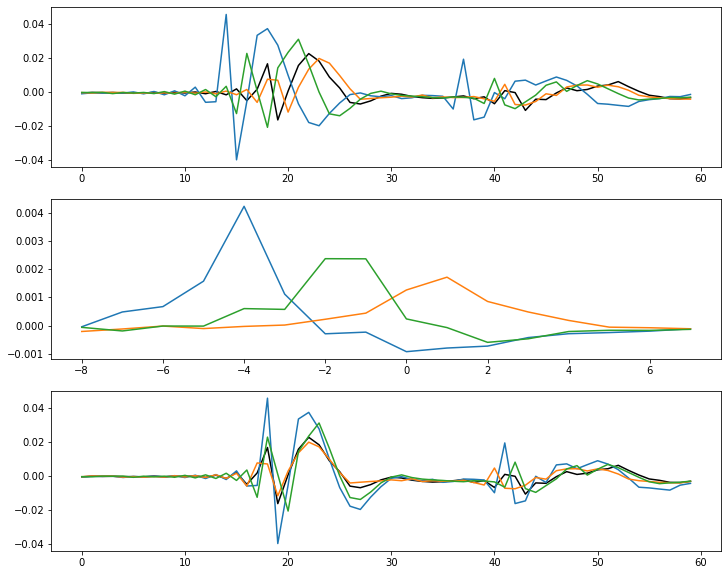

In [94]:
max_shift = 8
start = 20
end = 80
srir_sample = rirs[0][0][:,:,300]
base_channel = srir_sample[start:stop,0]
shifts = []

f, ax = plt.subplots(3,1, figsize=(12,10)) 
ax[0].plot(base_channel, 'k-')
ax[2].plot(base_channel, 'k-')


for i in range(3):
    shift_channel = srir_sample[:,i+1]
    ax[0].plot(shift_channel[start:stop])
    dist = []
    for shift in range(-max_shift, max_shift):
        dist.append(np.correlate(base_channel, shift_channel[start+shift:stop+shift])[0])
    shifts.append(np.argmax(dist)-max_shift)
    ax[1].plot(range(-max_shift, max_shift), dist)
    ax[2].plot(shift_channel[start+shifts[i]:stop+shifts[i]])
print(shifts)

In [100]:
def compute_delays(srir, start=20, end=80, max_shift=8):
    base_channel = srir[start:stop,0]
    shifts = []
    for i in range(srir.shape[1]-1):
        shift_channel = srir[:,i+1]
        dist = []
        for shift in range(-max_shift, max_shift):
            dist.append(np.correlate(base_channel, shift_channel[start+shift:stop+shift])[0])
        shifts.append(np.argmax(dist)-max_shift)
    return shifts

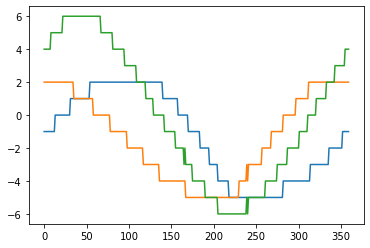

In [104]:
c1 = []
c2 = []
c3 = []
for i in range(360):
    delays = compute_delays(rirs[0][0][:,:,i])
    c1.append(delays[0])
    c2.append(delays[1])
    c3.append(delays[2])
plt.plot(c1)
plt.plot(c2)
plt.plot(c3)